# Application of continuous wavelet transform to feature extraction
## Bartosz Banasik: 229760


Needed imports:

In [0]:
import os
from pathlib import Path
import numpy as np
import pywt
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
import h5py

## Download and unpack the data

For data description look into the `README.txt` file. There is a chance that you will need to change the download file. Please check [UCI HAR dataset](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).



In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip

--2020-03-28 22:36:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  73.1MB/s    in 0.8s    

2020-03-28 22:36:21 (73.1 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]



In [0]:
!unzip "UCI HAR Dataset.zip"

Archive:  UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HAR

## Load the data

Read 9 component signals from `"Inertial Signals"` directory and read corresponding labels from `y*.txt` file. Labels are from 1-6, but to use categorical feautures from keras library we need them to start from 0. We also transpose X array  to obtain in each record 128 samples for 9 components.

In [0]:
def readData(root_directory: str):
    root_path = Path(root_directory)
    p = root_path / "Inertial Signals"
    x_paths = sorted(list(p.glob('*.txt')))
    y_path = list(root_path.glob('y*.txt'))[0]
    
    x = []
    print(x_paths)
    for x_p in x_paths:
      x.append(np.loadtxt(x_p, dtype=np.float32))

    y = to_categorical(np.loadtxt(y_path, dtype=np.int8) - 1 )
    return np.transpose(np.array(x), (1, 2, 0)), y


## Continous wavelet transform
Below is simple example of Continous wavelet transform.

In [0]:
def myCWT(vector):
    wavelet = "morl"
    coeff, freqs = pywt.cwt(vector, np.arange(1,129), wavelet)
    return coeff

## Create CNN input
Take the created arrays and apply CWT to each 9 components of each record. The result array shape should be `(n_samples, 128, 128, 9)`. We're using morlet real wavelet, and scale from 1 to 128.


In [0]:
def CWT(x, size):
  records = x.shape[0]
  components = x.shape[2]

  scale = np.arange(1, size + 1)
  wavelet = 'morl'

  ret_arr = np.ndarray(shape=(records, size, size, components), dtype=np.float32)
  for r in tqdm(range(records)):
    for c in range(components):
      coeffs, _ = pywt.cwt(x[r, :, c], scale, wavelet)
      ret_arr[r, :, :, c] = coeffs
  return ret_arr


In [0]:
x_train, y_train = readData("UCI HAR Dataset/train")
x_test, y_test = readData("UCI HAR Dataset/test")
x_train = CWT(x_train, 128)
x_test = CWT(x_test, 128)

[PosixPath('UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt'), PosixPath('UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt'), PosixPath('UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt'), PosixPath('UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt'), PosixPath('UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt'), PosixPath('UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt'), PosixPath('UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt'), PosixPath('UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt'), PosixPath('UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt')]
[PosixPath('UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt'), PosixPath('UCI HAR Dataset/test/Inertial Signals/body_acc_y_test.txt'), PosixPath('UCI HAR Dataset/test/Inertial Signals/body_acc_z_test.txt'), PosixPath('UCI HAR Dataset/test/Inertial Signals/body_gyro_x_test.txt'), PosixPath('UCI HAR Dataset/test/Inert

100%|██████████| 2947/2947 [05:16<00:00,  9.32it/s]


Due to high memory usage it's good to clear the garbage at the time.

In [0]:
import gc
gc.collect()

22

In [0]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_train.dtype)
print(x_train.nbytes)

(7352, 128, 128, 9) (7352, 6)
(2947, 128, 128, 9) (2947, 6)
float32
4336386048


## Pick one record and see all 9 components

Here we're gonna pick one record and display all 9 components that were produced from CWT.

In [0]:
def plot(x, y):
  labels = ["Walking", "Walking upstairs", "Walking downstairs", "Sitting", "Standing", "Laying"]
  fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
  for index, ax_id in enumerate(ax.flat):
    ax_id.imshow(x[:,:,index],aspect='auto', cmap="jet")
  fig.suptitle(labels[np.argmax(y)])
  plt.show()



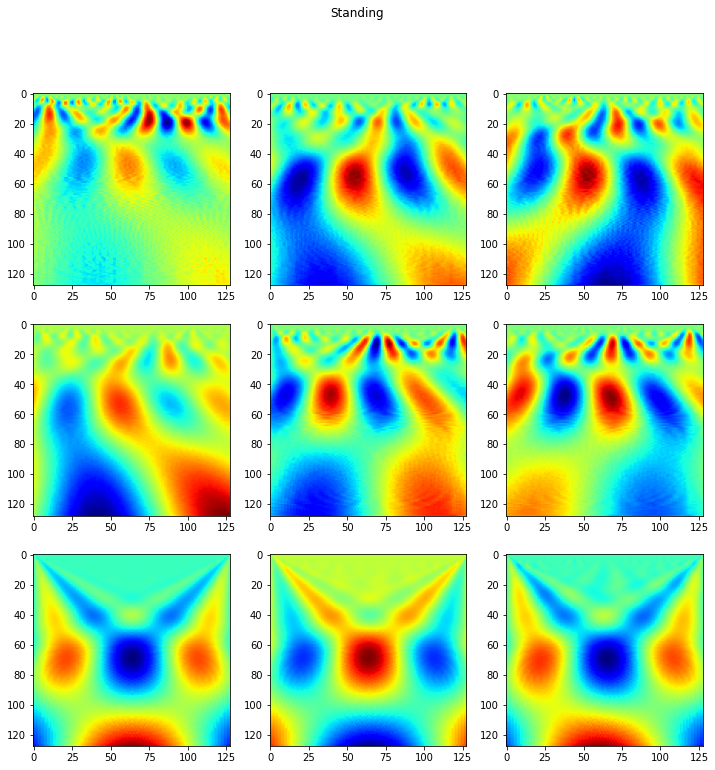

In [0]:
plot(x_test[4], y_test[4])

## Pick one component and display for different activity
Here we're gonna plot CWT coefficients for different activities to just one choosen component.

In [0]:
def find_indexes(y):
  indexes = []
  y_n = np.argmax(y, axis=-1)
  for label in sorted(np.unique(y_n)):
    indexes.append(np.where(y_n == label)[0][0])
  return indexes

In [0]:
def plot2(x, component, indexes):
  labels = ["Walking", "Walking upstairs", "Walking downstairs", "Sitting", "Standing", "Laying"]
  fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
  for ui, ax_id, idx in zip([i for i in range(7)], ax.flat, indexes):
    ax_id.imshow(x[idx,:,:,component],aspect='auto', cmap="jet")
    ax_id.set_title(labels[ui])
  plt.show()

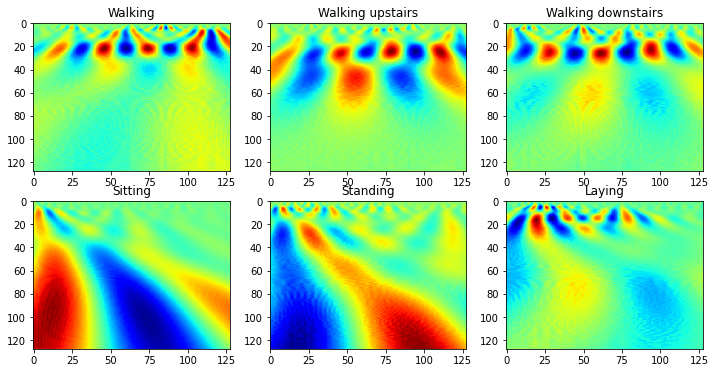

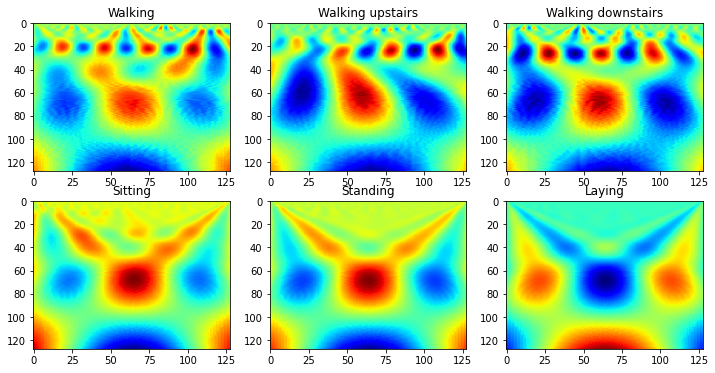

In [0]:
indxs = find_indexes(y_test)
plot2(x_test, 1, indxs)
plot2(x_test, 7, indxs)

## Create CNN model

As in the task description we're creating the simple CNN with 2 convolutional and 2 MaxPooling layers. After that we're adding flat classificator with 2 fully connected layers. On the output layer we have 6 neurons.


In [0]:
import gc
gc.collect()

0

In [0]:
#create model
model = Sequential()#add model layers
model.add(Conv2D(32, kernel_size=5, 
                 activation='relu', 
                 input_shape=(128,128,9)
                 )
)
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, kernel_size=5,
                 activation='relu' 
                 )
)
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(6, activation='softmax'))

This is classification to 6 different classes, so at the end of our classificator we have `softmax` activation function.
We're gonna use `Adadelta` optimizer and *categorical crossentropy* as a loss function.

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adadelta(),
             metrics=['accuracy'])

In [0]:
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    batch_size=16, epochs=10, verbose=1,
    shuffle=True,
)

Epoch 1/10
368/368 [==============================] - 8s 22ms/step - loss: 1.0972 - accuracy: 0.7472 - val_loss: 0.6372 - val_accuracy: 0.8532
Epoch 2/10
368/368 [==============================] - 8s 20ms/step - loss: 0.4945 - accuracy: 0.8672 - val_loss: 0.3999 - val_accuracy: 0.8770
Epoch 3/10
368/368 [==============================] - 8s 20ms/step - loss: 0.3432 - accuracy: 0.8963 - val_loss: 0.3210 - val_accuracy: 0.8858
Epoch 4/10
368/368 [==============================] - 7s 20ms/step - loss: 0.2768 - accuracy: 0.9114 - val_loss: 0.2850 - val_accuracy: 0.9055
Epoch 5/10
368/368 [==============================] - 7s 20ms/step - loss: 0.2377 - accuracy: 0.9163 - val_loss: 0.2720 - val_accuracy: 0.9014
Epoch 6/10
368/368 [==============================] - 7s 20ms/step - loss: 0.2107 - accuracy: 0.9254 - val_loss: 0.2544 - val_accuracy: 0.9082
Epoch 7/10
368/368 [==============================] - 7s 20ms/step - loss: 0.1913 - accuracy: 0.9308 - val_loss: 0.2448 - val_accuracy: 0.9137

Plot the loss and accuracy.

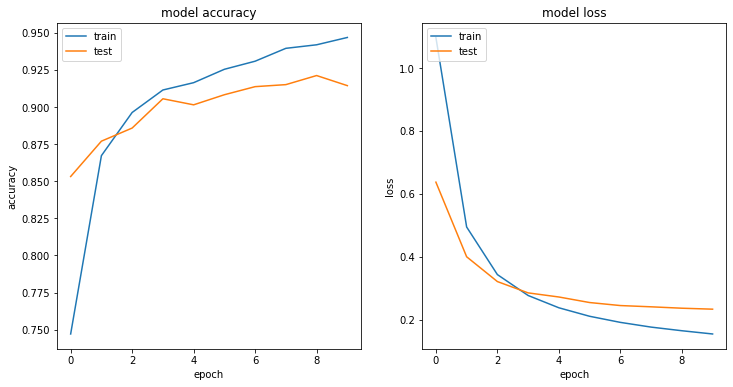

In [0]:
def plot_graphs(history):
  # summarize history for accuracy
  acc_key = "accuracy"
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
  ax1.plot(history.history[acc_key])
  ax1.plot(history.history['val_' + acc_key])
  ax1.set_title('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'test'], loc='upper left')

  # summarize history for loss
  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend(['train', 'test'], loc='upper left')
  plt.show()

plot_graphs(history)

We see that during training our validation accuracy reaches 91% and is not far away from the training accuracy. This means that the model  generalize well. Now lets check what is the estimation of the real accuracy:

In [0]:
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Test loss: 0.2667182981967926, Test accuracy: 0.9049881100654602
